<a href="https://colab.research.google.com/github/MarcoC1796/recommender-systems-thesis/blob/main/LatentFactorWithMovieDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys, importlib

user = "MarcoC1796"
repo = "recommender-systems-thesis"
src_dir = "src"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.append(path)

Cloning into 'recommender-systems-thesis'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 228 (delta 82), reused 73 (delta 42), pack-reused 110
Receiving objects: 100% (228/228), 97.80 MiB | 19.88 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Updating files: 100% (25/25), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.LatentFactorsCollabortiveFiltering import LatentFactorsCollaborativeFiltering

plt.style.use("ggplot")

In [4]:
path = "/content/drive/MyDrive/Thesis/Data/"
path += "ml-1m/ratings.dat"

rnames = ["user_id", "movie_id", "rating", "timestamp"]
movies = pd.read_table(path, sep="::", header=None, names=rnames, engine="python")
movies = movies.drop('timestamp', axis=1)


movies_im = pd.pivot_table(movies, values="rating", index="user_id", columns="movie_id")
movies_im.reset_index(drop=True, inplace=True)
movies_im.columns = range(movies_im.shape[1])
movies_im.rename_axis("user_id", axis="index", inplace=True)
movies_im.rename_axis("item_id", axis="columns", inplace=True)

stacked_series = movies_im.stack().dropna()
transformed_df = stacked_series.reset_index()
transformed_df.columns = ['user_id', 'item_id', 'rating']

R = movies_im.to_numpy()
num_users, num_items = R.shape
total_ratings = np.count_nonzero(~np.isnan(R))
total_posible_ratings = R.size
print(f"R is {round((total_ratings/total_posible_ratings)*100, 2)}% full with {total_ratings:,} ratings out of {total_posible_ratings:,} posible ratings, {num_users:,} users, and {num_items:,} items.")

movies_array = transformed_df[['user_id', 'item_id', 'rating']].values

train_val_set, test_set = train_test_split(movies_array, test_size=0.2, random_state=42)
print(f"Number of interactions in training and validation sets: {train_val_set.shape[0]:,}")
print(f"Number of interactions in test set: {test_set.shape[0]:,}")

R is 4.47% full with 1,000,209 ratings out of 22,384,240 posible ratings, 6,040 users, and 3,706 items.
Number of interactions in training and validation sets: 800,167
Number of interactions in test set: 200,042


In [ ]:
num_factors_list = [0,1,2] + list(range(5,101,5))
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  reg = 0
  learning_rate = 1e-2
  if num_factors > 100:
    learning_rate = 1e-3
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=512, learning_rate=learning_rate,reg_strength=reg)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

In [ ]:
num_factors_list = np.logspace(base=10,start=-2,stop=-1,num=5)
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=100,validation_interactions=test_set, epochs=8, batch_size=128, learning_rate=1e-2,reg_strength=num_factors)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

In [ ]:
from google.colab import files
import json

data_to_save = {
    "num_factors_list": num_factors_list,
    "train_errors_result_bias": train_errors_result_bias,
    "val_errors_result_bias":val_errors_result_bias
    # Add more data here
}
x = json.dumps (data_to_save)
y = x.encode('utf-8')
with open('example.txt', 'w') as f:
  f.write(str(y))

files.download('example.txt')

In [ ]:
variable_name = f'{num_factors_list=}'.split('=')[0]
print(variable_name)

In [ ]:
models[-1].item_embeddings[:,-5:]

In [ ]:
np.mean((models[-1].user_embeddings @ models[-1].item_embeddings.T))

In [ ]:

# Uncomment the following line to adjust the figure size if needed
# plt.figure(figsize=(8, 6))

biases = True

# Define a list of line styles, markers, and colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v']
colors = sns.color_palette('husl', len(num_factors_list))

for idx, (num_factors, train_errors, val_errors) in enumerate(zip(num_factors_list, train_errors_result_bias, val_errors_result_bias)):
    list1 = train_errors
    list2 = val_errors
    # Choose a distinct line style, marker, and color for each line
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    
    # Plotting the lists with distinct line style, marker, and color
    #plt.plot(list1[-4:], label=f'Training error | factors={num_factors} | biases={biases}', linestyle=line_style, marker=marker, color=color)
    plt.plot(list2[-4:], label=f'Validation error | factors={num_factors} | biases={biases}', linestyle=line_style, marker=marker, color=color)

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

In [ ]:
i = 1
min_train_errors = [min(val_errors) for val_errors in train_errors_result_bias]
min_val_errors= [min(val_errors) for val_errors in val_errors_result_bias]
plt.plot(num_factors_list[:], min_train_errors, label="train")
plt.plot(num_factors_list[:], min_val_errors, label = "val")
plt.legend()
plt.show()
print(num_factors_list[np.argmin(min_val_errors)])

In [ ]:
list1 = train_errors_result_bias[0]
list2= val_errors_result_bias[0]
# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
(models[1].user_embeddings @ models[1].item_embeddings.T)[~np.isnan(R)].max()

In [ ]:
models[1].item_embeddings[:,2].max()

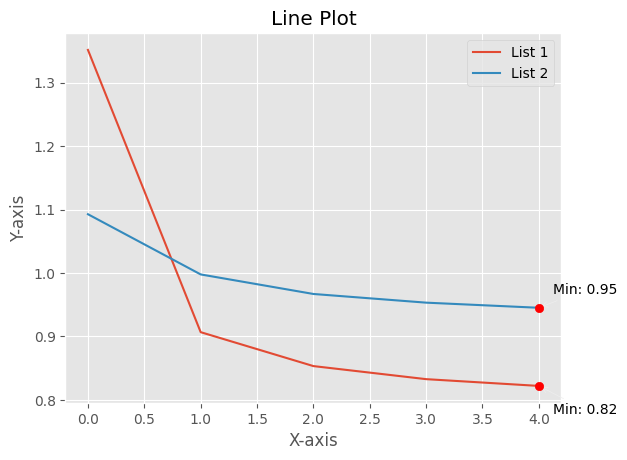

In [ ]:
list1 = train_errors
list2 = val_errors

# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from src.aux_functions import standardize_interactions
import inspect
lines = inspect.getsource(LatentFactorsCollaborativeFiltering)
print(lines)

In [ ]:
a = np.array([1, 2, 3, 4])
indices = np.array([0, 1, 0, 1])
values = np.array([10, 20, 30, 40])
np.add.at(a, indices, values)
print(a)

In [ ]:
a = np.array([1, 2, 3, 4])
indices = np.array([0, 1, 0, 1])
values = np.array([10, 20, 30, 40])
a[indices] += values
print(a)

In [ ]:
model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
train_errors, val_errors = model.fit(train_interactions=train_val_set, 
                                     num_factors=10,
                                     epochs=5, 
                                     batch_size=64, 
                                     learning_rate=0.01,
                                     reg_strength=0)

RMSE: None | Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/12503 [00:00<?, ?it/s]

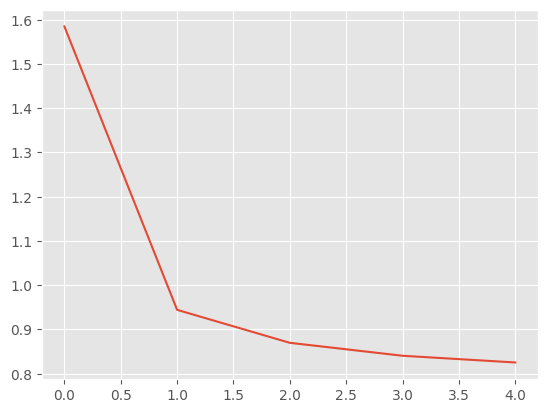

In [ ]:
plt.plot(train_errors)
plt.show()

In [ ]:
train_errors

[1.5932637178424072]

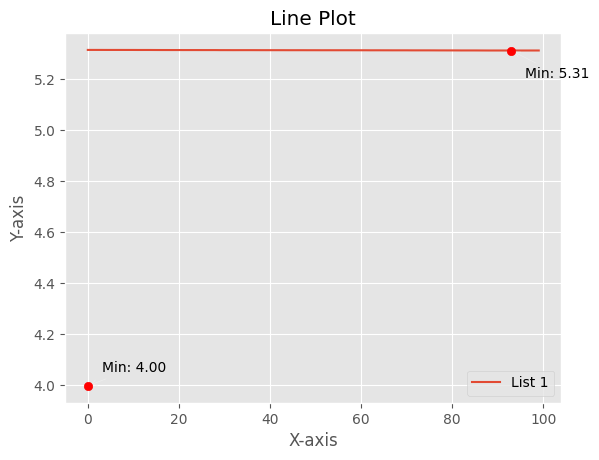

In [ ]:
list1 = train_errors
list2 = val_errors

# Plotting the lists
plt.plot(list1, label='List 1')
#plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [20]:
from src.aux_functions import standardize_interactions

class LatentFactorsCollaborativeFiltering:
    def __init__(
        self,
        num_users,
        num_items,
        num_factors=10,
        include_biases=True,
        standardize=True,
    ):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.include_biases = include_biases
        self.user_biases = None
        self.item_biases = None
        self.user_embeddings = None
        self.item_embeddings = None
        self.standardize = standardize
        self.mean_train = None
        self.std_train = None

    def fit(
        self,
        train_interactions,
        validation_interactions=None,
        num_factors=None,
        reg_strength=0,
        epochs=10,
        batch_size=128,
        learning_rate=0.01,
        tolerance=None,
        max_batches_per_epoch=None,
        compute_detailed_errors=False,
    ):
        if num_factors is not None:
            self.num_factors = num_factors

        if self.standardize:
            train_interactions, mean_train, std_train = standardize_interactions(
                train_interactions
            )
            self.mean_train = mean_train
            self.std_train = std_train
        else:
            _, mean_train, std_train = standardize_interactions(train_interactions)
            self.mean_train = mean_train
            self.std_train = std_train

        self.initililize_embeddings()

        train_errors = []
        validation_errors = []

        pbar_outer = trange(epochs, desc="RMSE: None | Progress: ", leave=False)

        for epoch in pbar_outer:
            np.random.shuffle(train_interactions)

            train_error = 0.0
            validation_error = 0.0

            num_batches = (
                int(np.ceil(len(train_interactions) / batch_size))
                if max_batches_per_epoch is None
                else max_batches_per_epoch
            )

            pbar_inner = trange(
                num_batches, desc=f"Epoch {epoch+1}/{epochs}", leave=False
            )

            for batch_idx in pbar_inner:
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch_interactions = train_interactions[start_idx:end_idx]

                errors = (
                    self.update_params(batch_interactions, learning_rate)
                    if not (reg_strength > 0)
                    else self.update_reg_params(
                        batch_interactions, learning_rate, reg_strength
                    )
                )
                train_error += np.sum(errors**2)

                if compute_detailed_errors:
                    current_error = self.evaluate_RMSE(train_interactions)
                    train_errors.append(current_error)

            if not compute_detailed_errors:
                train_errors.append(np.sqrt(train_error / len(train_interactions)))

            if validation_interactions is not None:
                validation_error = self.evaluate_RMSE(validation_interactions)
                validation_errors.append(validation_error)

            if tolerance is not None and epoch > 0:
                absolute_improvement = train_errors[-2] - train_errors[-1]
                if absolute_improvement < 0:
                    pbar_outer.set_description(
                        f"Early Stopping at Epoch {epoch+1} due to failure to improve RMSE | RMSE = {train_errors[-1]:.2e} | Progress"
                    )
                    break

                if absolute_improvement / train_errors[-2] < tolerance:
                    pbar_outer.set_description(
                        f"Early Stopping at Epoch {epoch+1} due to tolerance reached | RMSE = {train_errors[-1]:.2e}  | Progress"
                    )
                    break

            pbar_outer.set_description(f"RMSE: {train_errors[-1]:.2e} | Progress")

        pbar_outer.close()
        return train_errors, validation_errors

    def predict(self, user, item):
        user_embedding = self.user_embeddings[user]
        item_embedding = self.item_embeddings[item]
        return np.dot(user_embedding, item_embedding)

    def predict_batch(self, users, items):
        user_embeddings_batch = self.user_embeddings[users]
        item_embeddings_batch = self.item_embeddings[items]
        return np.sum(user_embeddings_batch * item_embeddings_batch, axis=1)

    def recommend_items(self, user, top_k=5):
        user_embedding = self.user_embeddings[user]
        scores = np.dot(self.item_embeddings, user_embedding)
        top_item_indices = np.argsort(scores)[::-1][:top_k]
        return top_item_indices

    def update_params(self, interactions, learning_rate):
        users, items, ratings = self.split_interactions(interactions)
        errors = ratings - self.predict_batch(users, items)

        user_gradients = errors[:, np.newaxis] * self.item_embeddings[items]
        item_gradients = errors[:, np.newaxis] * self.user_embeddings[users]

        np.add.at(self.user_embeddings, users, learning_rate * user_gradients)
        np.add.at(self.item_embeddings, items, learning_rate * item_gradients)

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

        return errors

    def update_reg_params(self, interactions, learning_rate, reg_strength):
        (
            errors,
            unique_users,
            user_gradients,
            unique_items,
            item_gradients,
        ) = self.compute_gradients(interactions, reg_strength)

        self.user_embeddings[unique_users] += learning_rate * user_gradients
        self.item_embeddings[unique_items] += learning_rate * item_gradients

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

        return errors

    def compute_gradients(self, interactions, reg_strength):
        users, items, ratings = self.split_interactions(interactions)

        predictions = self.predict_batch(users, items)
        errors = ratings - predictions

        user_gradients = errors[:, np.newaxis] * self.item_embeddings[items]
        item_gradients = errors[:, np.newaxis] * self.user_embeddings[users]

        unique_users, accumulated_user_gradients = self.accumulate_gradients(
            users, user_gradients
        )
        unique_items, accumulated_item_gradients = self.accumulate_gradients(
            items, item_gradients
        )

        accumulated_user_gradients -= reg_strength * self.user_embeddings[unique_users]
        accumulated_item_gradients -= reg_strength * self.item_embeddings[unique_items]

        return (
            errors,
            unique_users,
            accumulated_user_gradients,
            unique_items,
            accumulated_item_gradients,
        )

    def accumulate_gradients(self, indices, gradients):
        unique_indices, inverse = np.unique(indices, return_inverse=True)
        accumulated_gradients = np.zeros((unique_indices.shape[0], self.num_factors))
        np.add.at(accumulated_gradients, inverse, gradients)
        return unique_indices, accumulated_gradients

    def evaluate_RMSE(self, test_interactions):
        test_users, test_items, test_ratings = np.split(test_interactions, 3, axis=1)
        test_users = test_users.flatten().astype(int)
        test_items = test_items.flatten().astype(int)
        test_ratings = test_ratings.flatten()
        test_predictions = self.predict_batch(test_users, test_items)
        if self.standardize:
            test_predictions = test_predictions * self.std_train + self.mean_train
        errors = test_ratings - test_predictions
        test_rmse = np.sqrt(np.mean(errors**2))
        return test_rmse

    def initililize_embeddings(self):
        self.num_factors = (
            self.num_factors + 2 if self.include_biases else self.num_factors
        )

        loc = 0 if self.standardize else self.mean_train
        scale = 1 if self.standardize else self.std_train

        self.user_embeddings = np.random.default_rng().normal(
            loc=loc, scale=scale, size=(self.num_users, self.num_factors)
        )
        self.item_embeddings = np.random.default_rng().normal(
            loc=loc, scale=scale, size=(self.num_items, self.num_factors)
        )

        if self.include_biases:
            self.user_embeddings[:, -1] = 1
            self.item_embeddings[:, -2] = 1

    def split_interactions(self, interactions):
        users, items, ratings = np.split(interactions, 3, axis=1)
        users = users.flatten().astype(int)
        items = items.flatten().astype(int)
        ratings = ratings.flatten()
        return users, items, ratings

In [30]:
reg_list = np.append(0, np.logspace(base=2,start=-5,stop=1,num=7))
train_errors_result = []
val_errors_result = []
models = []

pbar = tqdm(reg_list)
for reg_strength in pbar:
  pbar.set_description(f"Current Reg: {reg_strength} | Progress")
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  train_errors, val_errors = model.fit(train_interactions=train_val_set, 
                                       validation_interactions=test_set,
                                       num_factors=50,
                                       epochs=20, 
                                       batch_size=512, 
                                       learning_rate=1e-2,
                                       reg_strength=reg_strength)
  train_errors_result.append(train_errors)
  val_errors_result.append(val_errors)
  models.append(model)

  0%|          | 0/8 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

RMSE: None | Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/1563 [00:00<?, ?it/s]

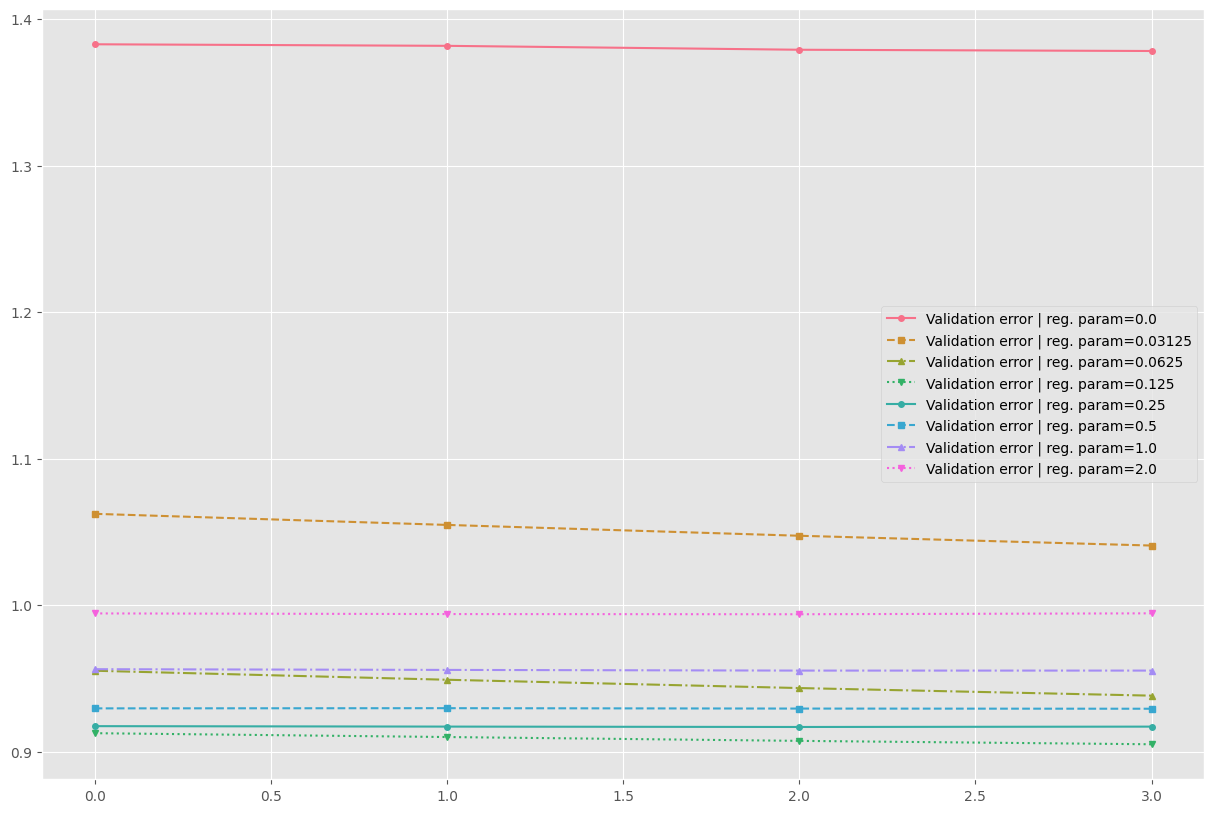

In [42]:
plt.figure(figsize=(15, 10))

biases = True

# Define a list of line styles, markers, and colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v']
colors = sns.color_palette('husl', len(reg_list))

for idx, (num_factors, train_errors, val_errors) in enumerate(zip(reg_list, train_errors_result, val_errors_result)):
    list1 = train_errors
    list2 = val_errors
    # Choose a distinct line style, marker, and color for each line
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    
    # Plotting the lists with distinct line style, marker, and color
    #plt.plot(list1[-4:], label=f'Training error | reg. param={num_factors}', linestyle=line_style, marker=marker, color=color,markersize=4)
    plt.plot(list2[-4:], label=f'Validation error | reg. param={num_factors}', linestyle=line_style, marker=marker, color=color, markersize=4)

# Move the legend outside the plot area
# bbox_to_anchor=(1.02, 0.5), loc='center left'
plt.legend()

plt.show()

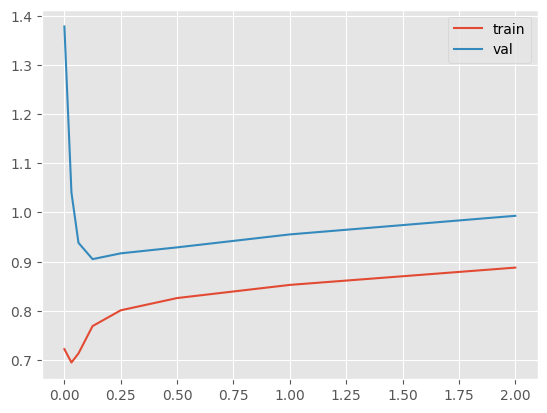

0.125


In [45]:
i = 1
min_train_errors = [min(val_errors) for val_errors in train_errors_result]
min_val_errors= [min(val_errors) for val_errors in val_errors_result]
plt.plot(reg_list[:], min_train_errors, label="train")
plt.plot(reg_list[:], min_val_errors, label = "val")
plt.legend()
plt.show()
print(reg_list[np.argmin(min_val_errors)])

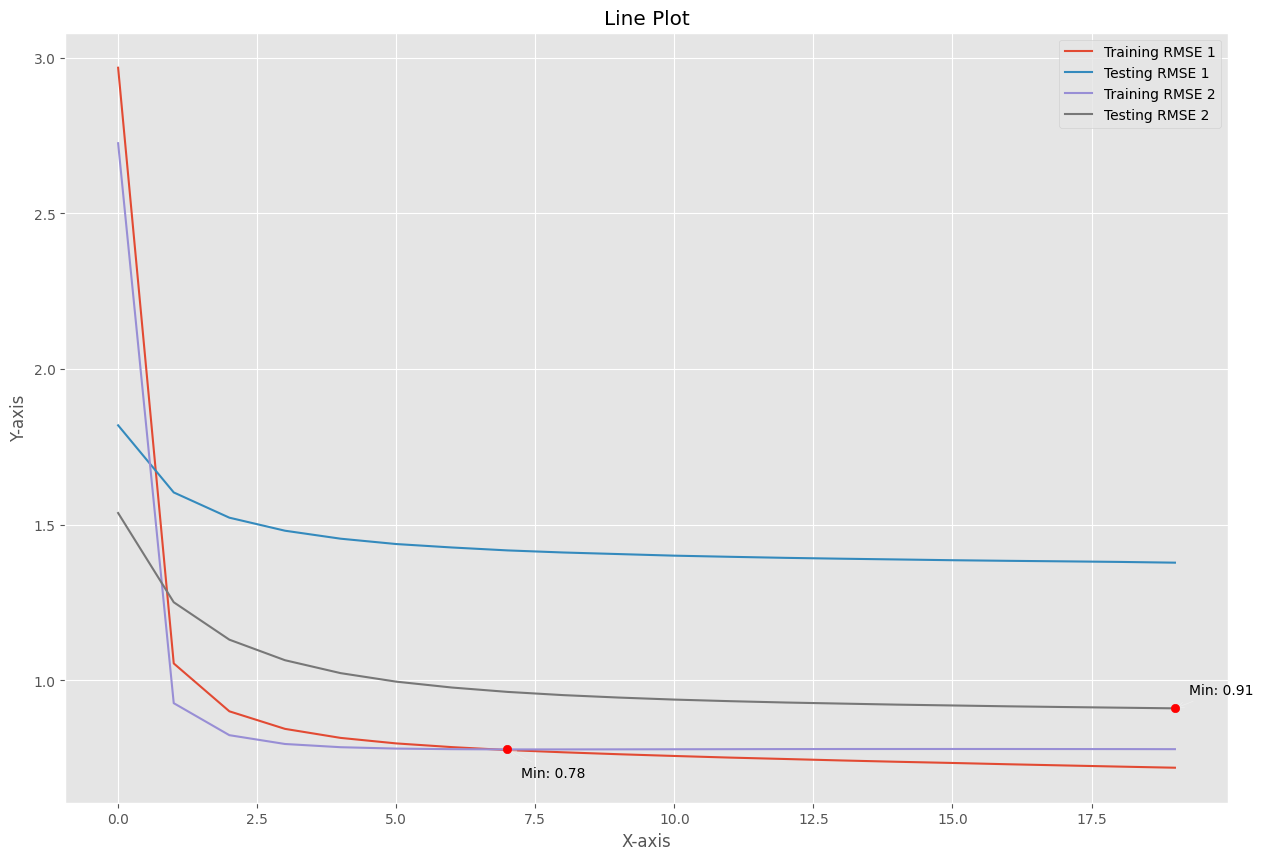

In [48]:
list1 = train_errors_result[0]
list2 = val_errors_result[0]

plt.figure(figsize=(15,10))
# Plotting the lists
plt.plot(list1, label='Training RMSE 1')
plt.plot(list2, label='Testing RMSE 1')
list1 = train_errors_result[3]
list2 = val_errors_result[3]
plt.plot(list1, label='Training RMSE 2')
plt.plot(list2, label='Testing RMSE 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [6]:
import inspect
lines = inspect.getsource(LatentFactorsCollaborativeFiltering)
print(lines)

class LatentFactorsCollaborativeFiltering:
    def __init__(
        self,
        num_users,
        num_items,
        num_factors=10,
        include_biases=True,
        standardize=True,
    ):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.include_biases = include_biases
        self.user_biases = None
        self.item_biases = None
        self.user_embeddings = None
        self.item_embeddings = None
        self.standardize = standardize
        self.mean_train = None
        self.std_train = None

    def fit(
        self,
        train_interactions,
        validation_interactions=None,
        num_factors=None,
        reg_strength=0,
        epochs=10,
        batch_size=128,
        learning_rate=0.01,
        tolerance=None,
        max_batches_per_epoch=None,
        compute_detailed_errors=False,
    ):
        if num_factors is not None:
            self.num_factors = num_factors

        if

In [48]:
from google.colab import files
import json

to_download = {
    "reg_list": reg_list.tolist(),
    "train_errors_result": train_errors_result,
    "val_errors_result": val_errors_result
}
x = json.dumps (to_download)
y = x.encode('utf-8')
with open('example.txt', 'w') as f:
  f.write(str(y))

files.download('example.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>